In [45]:
import numpy as np 
import scipy as sc
import numpy.linalg
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from numba import jit, prange

plt.style.use('seaborn-white')
%matplotlib notebook

# Visualization of a single trajectory

In [ ]:
np.random.seed(42)
V = lambda x: 1/2*(x**2-1)**2
gradV = lambda x: 2*x*(x**2-1)
dt = 0.01
sdt = np.sqrt(dt)
beta = 2.0
sigma = np.sqrt(2.0/beta)
N = 1000
mc_steps = 10
Xzero = -1
left_bound = 0.9
right_bound = 1.1

Xem = np.zeros(N)
Xem[0] = Xzero

for j in range(1,N):
    dW = np.sqrt(dt)*np.random.randn(1)
    Xem[j] = Xem[j-1] -gradV(Xem[j-1])*dt + np.sqrt(2*beta)*dW 
    
    if (Xem[j] > left_bound) & (Xem[j] < right_bound):
        break
            
fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1)
ax.plot(np.linspace(-2,2,500),V(np.linspace(-2,2,500)))
ax.plot(Xem,V(Xem),'ro')
ax.set_xlabel('$x$',fontsize=16)
ax.set_ylabel('$V(x)$',fontsize=16,rotation=0)
ax.set_title('Plot a single path with {} steps with beta:{}'.format(j,beta),fontsize=16)

# Monte Carlo Estimator

In [71]:
def monte_carlo(x0,dt,beta,gradV,hset,mc_steps=100,tlen=100):

    ht = np.zeros(mc_steps)
    sigma = np.sqrt(2.0/beta)

    for k in range(mc_steps):
        xtemp = x0
        t=0
    
        for j in range(tlen):
            dbt = np.sqrt(dt)*np.random.randn(1)
            xtemp += -gradV(xtemp)*dt + sigma*dbt
            t += dt 
    
            if (xtemp > hset[0]) & (xtemp < hset[1]):
                ht[k] = t
                break
    
    rht = ht[ht>0]
    mean_ht = rht.mean()
    var_ht = rht.var()
    func_ht = np.exp(-beta*rht).mean()
    print('Mean hitting time for beta={} is {:.4f}'.format(beta,mean_ht))
    print('E[exp(-beta*tau)] for beta={} is {:.4f}'.format(beta,func_ht))
    print('Variance of the hitting time for beta={} is {:.4f}'.format(beta,var_ht))
    print('Number of trajectories used {}'.format(np.sum(ht>0)))

In [73]:
np.random.seed(42)
V = lambda x: 1/2*(x**2-1)**2
gradV = lambda x: 2*x*(x**2-1)
xzero= -1; dt = 0.01; beta = 2
hset = [0.9,1.1]; mc_steps = 10000
monte_carlo(xzero,dt,beta,gradV,hset,mc_steps)

Mean hitting time for beta=2 is 0.7524
E[exp(-beta*tau)] for beta=2 is 0.2364
Variance of the hitting time for beta=2 is 0.0296
Number of trajectories used 510


# Importance Sampling with Girsanov

In [77]:
def importance_sampling(x0,dt,beta,gradV,hset,bias,mc_steps=100,tlen=100):
    
    sigma = np.sqrt(2.0/beta)

    ht = np.zeros(mc_steps)
    gs = np.zeros(mc_steps)
    gd = np.zeros(mc_steps)

    for k in range(mc_steps):
        xtemp = x0
        Gs = 0
        Gd = 0
        t=0

        for j in range(tlen):
            dbt = np.sqrt(dt)*np.random.randn(1)
            xtemp += -(gradV(xtemp)+bias)*dt + sigma*dbt
            # u_0 = sigma^-1*(b-a)
            # b = -\nabla V
            # a = -\nabla(V+U)
            # => u_0 =  sigma^-1 (-\nabla U) 
            gy = 1/sigma * (- bias)
            Gs += -gy*dbt
            Gd += -1/2*gy**2*dt
            t += dt 

            if (xtemp > hset[0]) & (xtemp < hset[1]):
                ht[k] = t
                gs[k] = Gs
                gd[k] = Gd
                break

    rht = ht[ht>0]
    rgs = gs[ht>0]; rgd = gd[ht>0]
    mean_ht = rht.mean()
    func_ht = np.exp(-beta*rht)*np.exp(rgs+rgd)
    mean_mfht = func_ht.mean()
    mean_girsanov = np.exp(rgs+rgd).mean()

    print('IS for Mean hitting time for beta={} is {:.4f}'.format(beta,mean_ht))
    print('IS for E[exp(-beta*tau)] for beta={} is {:.4f}'.format(beta,mean_mfht))
    print('IS Variance of the hitting time for beta={} is {:.4f}'.format(beta,func_ht.var()))
    print('Numbers of used trajectories: {}'.format(np.sum(ht>0)))
    print('Mean of Girsanov weights {}'.format(mean_girsanov))

In [80]:
np.random.seed(21)
V = lambda x: 1/2*(x**2-1)**2
gradV = lambda x: 2*x*(x**2-1)
x0 = -1; dt = 0.01
beta = 2.0; tlen = 100
mc_steps = 10000
hset = [0.9, 1.1]
bias = -1

importance_sampling(x0,dt,beta,gradV,hset,bias,mc_steps,tlen=100)

IS for Mean hitting time for beta=2.0 is 0.7306
IS for E[exp(-beta*tau)] for beta=2.0 is 0.0498
IS Variance of the hitting time for beta=2.0 is 0.0003
Numbers of used trajectories: 2329
Mean of Girsanov weights 0.2086557606883574


# Example Girsanov from Oksendal

In [76]:
np.random.seed(42)
n_steps =1000
dt= 0.0001
mc_steps = 1000


Gs = np.zeros(mc_steps)
Gd = np.zeros(mc_steps)
ht = np.zeros(mc_steps)
endPx = np.zeros(mc_steps)
endPy = np.zeros(mc_steps)

a = 1
beta = 1/3
hit = 3

for i in range(mc_steps):
    x = 2
    y = x
    gs = 0
    gd = 0
    t=0
    
    for k in range(n_steps):
        dW = np.sqrt(dt)*np.random.randn(1)
        sigma = np.sqrt(2*beta)
        b_drifft = 0
        a_drifft = a*y
        x += a_drifft*dt + sigma*dW
        y += b_drifft*dt + sigma*dW
        t +=dt
    
        gy = 1/sigma*(b_drifft-a_drifft)
        gs += -gy*dW
        gd += -1/2*gy**2*dt
    
        #if (x > hit):
        #    ht[i] = t
        #    Gs[i] = gs
        #    Gd[i] = gd
        #    break
            
    endPx[i] = x
    endPy[i] = y
    Gs[i] = gs
    Gd[i] = gd
    
Ex = endPx
Ey = endPy*np.exp(Gs+Gd)

print('Average Ex {:.8f}'.format(np.mean(Ex)))
print('Average Ey {:.8f}'.format(np.mean(Ey)))
print('Var Ex {:.8f}'.format(np.var(Ex)))
print('Var Ey {:.8f}'.format(np.var(Ey)))

Average Ex 2.18641784
Average Ey 2.15080946
Var Ex 0.07635563
Var Ey 8.50285419


# 2D Potential

In [ ]:
V = lambda x,y: (1-x**2)**2+(1-y**2)**2+(x*y)/2+y/5
gradVx = lambda x,y: -4*x*(1-np.power(x,2)) + y/2
gradVy = lambda x,y: -4*y*(1-np.power(y,2)) + x/2 + 1/5

n_steps = 10000

dt = 0.001
xzero = -1; yzero = 1
xem = np.zeros(n_steps);yem = np.zeros(n_steps)
xem[0] = xzero; yem[0] = yzero
beta_x = 1; beta_y = 1;
sigma_x = np.sqrt(2*1/beta_x); sigma_y = np.sqrt(2*1/beta_y)


for j in range(1,n_steps):
    dW = np.sqrt(dt)*np.random.randn(2)
    
    xem[j] = xem[j-1] -gradVx(xem[j-1],yem[j-1])*dt + sigma_x *dW[0]
    yem[j] = yem[j-1] -gradVy(xem[j-1],yem[j-1])*dt + sigma_y *dW[1]
    
    if (xem[j] > 1.8): #xem = 2 -> xem_new = -1.8 +(xem-1.8) 
        xem[j] = -3.6 + xem[j]
    if (yem[j] > 1.8):
        yem[j] = -3.6 + yem[j]
    if (xem[j] < -1.8): #xem = -2 -> xem_new = 1.8 + (xem+1.8)
        xem[j] = 3.6 + xem[j]
    if (yem[j] < -1.8):
        yem[j] = 3.6 + yem[j]

fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1)
x = np.linspace(-1.8,1.8,100)
y = np.linspace(-1.8,1.8,100)
xp,yp = np.meshgrid(x,y)
zp = V(xp,yp)
ax.contourf(xp,yp,zp,20,cmap='RdGy')
ax.plot(xem,yem,'k+')
ax.set_xlabel('x',fontsize=16)
ax.set_ylabel('y',fontsize=16,rotation=0)
ax.set_title('Plotting a single trajectory')

fig1 = plt.figure(figsize=(8,6))
ax1 = plt.axes(projection='3d')
ax1.contour3D(xp, yp, zp, 50, cmap='binary')
ax1.plot3D(xem,yem,V(xem,yem),'r.')
ax1.view_init(45, 63)


# 2D Monte Carlo Estimator

In [ ]:
V = lambda x,y: (1-x**2)**2+(1-y**2)**2+(x*y)/2+y/5
gradVx = lambda x,y: -4*x*(1-np.power(x,2)) + y/2
gradVy = lambda x,y: -4*y*(1-np.power(y,2)) + x/2 + 1/5

mc_steps = 1
Eht = np.zeros(mc_steps)
ht = np.zeros(mc_steps)

n_steps = 10000
dt = 0.001
xzero = -1; yzero = 1
beta = 1; 
sigma = np.sqrt(2*1/beta);
set_x = 1; set_y=-1;r=0.1


for n in range(mc_steps):
    xem = xzero; yem = yzero; t=0
    for j in range(1,n_steps):
        dW = np.sqrt(dt)*np.random.randn(2)

        xem += -gradVx(xem,yem)*dt + sigma *dW[0]
        yem += -gradVy(xem,yem)*dt + sigma *dW[1]
        t+=dt


        if (xem > 1.8): #xem = 2 -> xem_new = -1.8 +(xem-1.8) 
            xem = -3.6 + xem
        if (yem > 1.8):
            yem = -3.6 + yem
        if (xem < -1.8): #xem = -2 -> xem_new = 1.8 + (xem+1.8)
            xem = 3.6 + xem
        if (yem < -1.8):
            yem = 3.6 + yem
        
        if (((xem -set_x) + (yem-set_y))**2 < r):
            ht[n] = t
            break
            
Ex = np.exp(-beta*ht)
print('Average Monte Carlo Estimator {}'.format(Ex.mean()))
print('Variacne Monte Carlo Estimator {}'.format(Ex.var()))

# 2D Girsanov

In [ ]:
V = lambda x,y: (1-x**2)**2+(1-y**2)**2+(x*y)/2+y/5
gradVx = lambda x,y: -4*x*(1-np.power(x,2)) + y/2
gradVy = lambda x,y: -4*y*(1-np.power(y,2)) + x/2 + 1/5

mc_steps = 100
Eht = np.zeros(mc_steps)
G = np.zeros(mc_steps)
ht = np.zeros(mc_steps)

n_steps = 10000
dt = 0.001
xzero = -1; yzero = 1
beta = 1; 
sigma = np.sqrt(2/beta);
set_x = 1; set_y=-1
bias = [bias_x,bias_y]

for n in range(mc_steps):
    xem = xzero; yem = yzero; t=0
    gs = 0; gd = 0;
    for j in range(1,n_steps):
        dW = np.sqrt(dt)*np.random.randn(2)

        xem += -(gradVx(xem,yem)+bias[0])*dt + sigma *dW[0]
        yem += -(gradVy(xem,yem)+bias[1])*dt + sigma *dW[1]
        t+=dt

        gs += 1/sigma*np.dot(bias,dW)
        gd += -1/2 * 1/sigma**2 * np.power(bias,2).sum()*dt

        if (xem > 1.8): #xem = 2 -> xem_new = -1.8 +(xem-1.8) 
            xem = -3.6 + xem
        if (yem > 1.8):
            yem = -3.6 + yem
        if (xem < -1.8): #xem = -2 -> xem_new = 1.8 + (xem+1.8)
            xem = 3.6 + xem
        if (yem < -1.8):
            yem = 3.6 + yem
            
        if (((xem - set_x) + (yem - set_y))**2 < r): 
            G[n] = np.exp(gs+gd)
            ht[n] = t
            break

Ex = np.exp(-beta*ht)*G
print('Average Girsanov Estimator {}'.format(Ex.mean()))
print('Variance Girsanov Estimator {}'.format(Ex.var()))

# Metadynamics and Girsanov

In [ ]:
np.random.seed(42)
V = lambda x: 1/2*(x**2-1)**2
gradV = lambda x: 2*x*(x**2-1)
dt = 0.01
sdt = np.sqrt(dt)
beta = 1.0/10.0
sigma = np.sqrt(2.0*beta)
N = 1000
def calculate_bias(x,n_means,sigma):
    if len(n_means) == 0:
        return [0.0]
    return [np.exp(-0.5*np.power(x-n_means[i],2)/np.power(2*sigma[i],2))/(np.sqrt(2*np.pi*sigma[i])) for i in range(len(n_means))]

def calculate_dbias(x,n_means,sigma):
    if len(n_means) == 0:
        return [0.0]
    return [np.exp(-(x-n_means[i])/np.power(sigma[i],2)*np.power(x-n_means[i],2)/np.power(2*sigma[i],2))/(np.sqrt(2*np.pi*sigma[i])) for i in range(len(n_means))]


In [ ]:
def construct_bias_potential(x0,bounds,scale):
    xtemp = x0
    l_bound = bounds[0]
    r_bound = bounds[1]
    count = 0
    t = 0
    omega = scale
    xm = []; xhelp = []; bias_sigma = []
    while True:
        if (xtemp > l_bound) & (xtemp < r_bound):
            break
        if (t > 0) & (t % 200 == 0):
            xm.append(np.mean(xhelp)) 
            bias_sigma.append(np.max(np.abs(np.array(xhelp)-xm[count]))*10)
            xhelp = []
            count +=1

        dV_bias= omega*np.sum(calculate_dbias(xtemp,xm,bias_sigma))
        #dV_bias = omega*np.sum(Bx) 
        dbt = np.sqrt(dt) * np.random.randn(1)
        xtemp += -(gradV(xtemp) + dV_bias )*dt + sigma * dbt
        xhelp.append(xtemp[0])
        t += 1

        if count > 1000: 
            print('No bias potential found!')
            return
    print('Trajectory reached the hitting set in {} timesteps!'.format(t))
    print('The bias potential has {} ansatz functions'.format(count))
    return xm, bias_sigma

In [ ]:
def reweighted_monte_carlo(x0,mu,theta,mc_steps):
    traj_count = 0
    for k in range(mc_steps):
        xtemp = x0
        Gs = 0
        Gd = 0
        t=0


        while True:
            #pdb.set_trace()
            dbt = np.sqrt(dt)*np.random.randn(1)
            dV_bias= omega*np.sum(calculate_dbias(xtemp,mu,theta))
            xtemp += -(gradV(xtemp)+dV_bias)*dt + sigma*dbt
            # u_0 = sigma^-1*(b-a)
            # b = -\nabla V
            # a = -\nabla(V+U)
            # => u_0 =  sigma^-1 (-\nabla U) 
            gy = 1/sigma * (- dV_bias)
            Gs += -gy*dbt
            Gd += -1/2*gy**2*dt
            t += dt 

            if (xtemp > left_bound) & (xtemp < right_bound):
                ht[k] = t
                gs[k] = Gs
                gd[k] = Gd
                traj_count +=1
                break
            if t> 10000*dt:
                break


    mean_ht = ht.mean()
    func_ht = np.exp(-beta*ht)*np.exp(gs+gd)
    mean_fht = func_ht.mean()

    print('IS for Mean hitting time for beta={} is {:.4f}'.format(beta,mean_ht))
    print('IS for E[exp(-beta*tau)] for beta={} is {:.4f}'.format(beta,mean_fht))
    print('IS Variance of the hitting time for beta={} is {:.4f}'.format(beta,func_ht.var()))
    print('Number of used trajectories {} from {}'.format(traj_count, mc_steps))

In [ ]:
xzero = -1
bounds = [0.9,1.1]
omega = -1/5.0
mu, theta = construct_bias_potential(xzero,bounds,omega)
reweighted_monte_carlo(xzero,mu,theta,10)

# HJB Löser

/home/jate1/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Text(0.5, 1.0, '-Grad V + u')

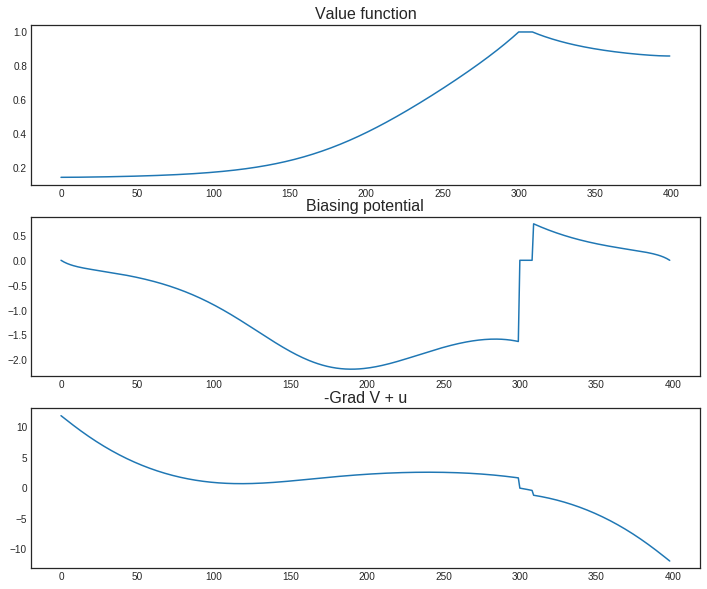

In [2]:
bl = -2 #bound left
br = 2 # bound right
dx = 0.01 # discretization
n_points = int(np.ceil((br-bl)/dx)) # number of points
x_space = np.linspace(bl,br,n_points) # domain
beta = 1.0
grad_V = lambda x: 2*x*(x**2-1) 
Lj = np.zeros([n_points,n_points])
f = np.ones(n_points)
b  = np.zeros([n_points,1])
bounds = [1.0,1.1]

# build the generator of the BVP
# Hauptdiagonale \beta^-1 \nabla^2 \psi -f \psi
# Nebendigonale \nabla V \nabla \spi
Lj = 1/(beta*dx**2)*diags([1,-2,1],[-1,0,1], shape=(n_points,n_points)) - diags(f) + \
   np.dot(-1*diags(grad_V(x_space)),1/(2*dx)*diags([-1,0,1],[-1, 0, 1], shape=(n_points,n_points))) 
# define the hitting set
hit_set_index = np.argwhere((x_space > bounds[0]) & (x_space < bounds[1]))
for item in hit_set_index:
    b[item] = 1 # exp(g(x)) mit g = 0 
    Lj[item,:] = 0
    Lj[item,item] = 1
# numerical stability    
#L[0, :] = 0
Lj[0, 0] = -Lj[0,1]
#L[0, 1] = -1
#b[0] = - 1*grad_V(x_space[0])*1/(2*dx)

#L[n_points-1, :] = 0
Lj[n_points-1, n_points-1] = -Lj[n_points-1, n_points-2]
#L[n_points-1, n_points-2] = -1
#b[n_points-1] = 1*grad_V(x_space[-1])*1/(2*dx) 


psi = spsolve(Lj,b) 
u_pde = -2/(beta*dx) * (np.log(psi[1:])-np.log(psi[:-1]))

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(311)
ax1.plot(psi)
ax1.set_title('Value function',fontsize=16)

ax2 = fig.add_subplot(312)
ax2.plot(u_pde)
ax2.set_title('Biasing potential',fontsize=16)

ax3 = fig.add_subplot(313)
ax3.plot(-grad_V(x_space[1:])-u_pde)
ax3.set_title('-Grad V + u', fontsize=16)

# 1D Kernel Example

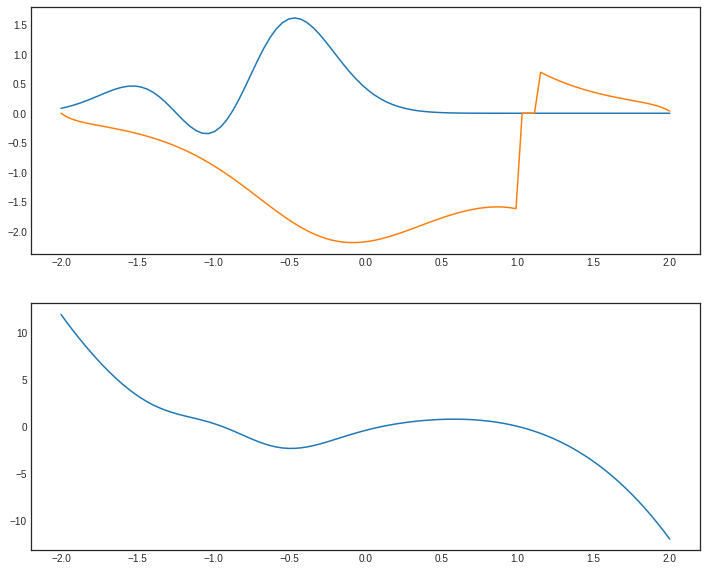

In [11]:
# parameters for the simulation of the path
gradV = lambda x: 2*x*(pow(x,2)-1)
dt = 0.01
sdt = np.sqrt(dt)
beta = 2.0
sigma = np.sqrt(2.0/beta)
dV_bias = 0

nvs = 1
ntrjs = 20
opt_steps = 1 
nsteps = 150
npred = 100
sk = 10 
eta = 0.3
pathfunc = np.ones((ntrjs,1))
cold = np.zeros((opt_steps,npred))
cpred = 0.0
c=0.0
time = [nsteps]*ntrjs; data = []; pathfunc=[1]*ntrjs; dw=[]

for opt in range(0, opt_steps):
    
# Sampling Trajectories
    for i in range(0,ntrjs):
        Gs = 0
        Gd = 0
                
        x = -1
        #data.append(x)
        # simulation of the path
        for j in range(nsteps):
            r = np.random.randn(1)[0]
            
            data.append(x)
            dw.append(r)
            
            dbt = np.sqrt(dt)*sigma*r
            x += -(gradV(x)+dV_bias)*dt + dbt
            
            
            
            # Update Girsanov
            gy = 1/sigma * (- dV_bias)
            Gs += -gy*dbt
            Gd += -1/2*gy**2*dt
            
            # stop if taget set is reached
            if (x > 0.9 and x < 1.1):
                time[i] = j+1
                pathfunc[i]= np.exp(-beta*j*dt+Gs+Gd)
                break
            
        


len_data = len(data)           
data = np.array(data)  
K = np.zeros((len_data,len_data))
path_data =[]
[path_data.append(pathfunc[j]) for j in range(ntrjs) for i in range(time[j])]

# print(len(data))
# print(len(path_data))
# print(len(dw))

for j in range(len_data):
    K[j,:] = np.array((path_data)) * sk/np.sqrt(2*np.pi)*eta**2*np.exp(-0.5*((data-data[j])**2)/eta**2)

A = -1/sigma**2*K*dt + ntrjs * np.eye(len_data,len_data)
b = 1/sigma*np.dot(K,dw) 

u0= np.linalg.solve(A,b)



def kernel_bias(xh,htime,tdata,u0,pathfunc):
    htime.insert(0,0)
    u = np.zeros(len(xh))
    for n in range(len(htime)-1):
        tdata = data[htime[n]:htime[n]+htime[n+1]]
        dbt = dw[htime[n]:htime[n]+htime[n+1]]
        udata = u0[htime[n]:htime[n]+htime[n+1]]
        s1=np.zeros(len(xh)); s2=np.zeros(len(xh));
        for i in range(len(tdata)):
            s1 += 1/sigma*sk/np.sqrt(2*np.pi)*eta**2 *np.exp(-0.5*((xh-tdata[i])**2)/eta**2)  * dbt[i]
            s2 += -1/sigma**2 * sk/np.sqrt(2*np.pi)*eta**2*np.exp(-0.5*((xh-tdata[i])**2)/eta**2) * u0[i]*dt
        u += pathfunc[n] *(s1+s2)
        #print(n)
    return -1/ntrjs *u 

x_plot = np.linspace(-2,2,100)
u_plot = kernel_bias(x_plot,time,data,u0,pathfunc)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(211)
ax.plot(x_plot,u_plot)
ax.plot(x_plot,u_pde[range(0,len(u_pde),4)])

ax1 = fig.add_subplot(212)
ax1.plot(x_plot,-(gradV(x_plot)+u_plot))

# 1D Kernel auf Potential

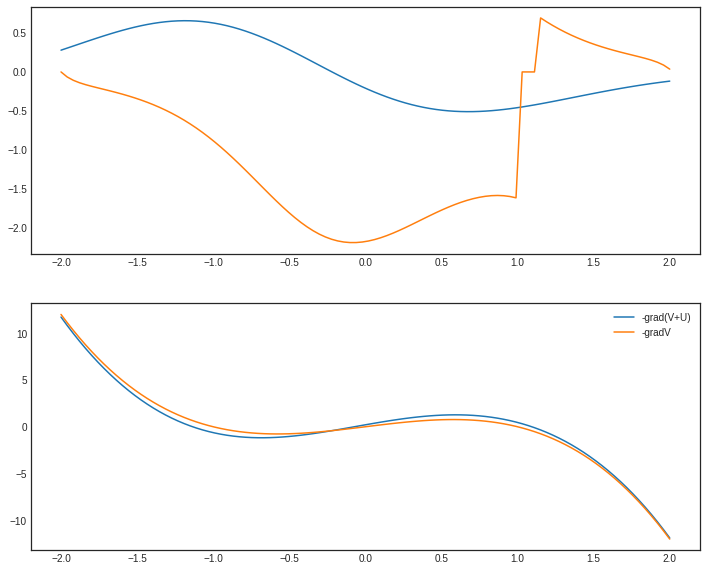

In [36]:
# parameters for the simulation of the path
gradV = lambda x: 2*x*(pow(x,2)-1)
dt = 0.01
sdt = np.sqrt(dt)
beta = 2.0
sigma = np.sqrt(2.0/beta)
dV_bias = 0

nvs = 1
ntrjs = 20
opt_steps = 1 
nsteps = 150
npred = 100
sk = 0.5 
eta = 1
pathfunc = np.ones((ntrjs,1))
cold = np.zeros((opt_steps,npred))
cpred = 0.0
c=0.0
time = [nsteps]*ntrjs; data = []; pathfunc=[1]*ntrjs; dw=[]

for opt in range(0, opt_steps):
    
# Sampling Trajectories
    for i in range(0,ntrjs):
        Gs = 0
        Gd = 0
                
        x = -1
        #data.append(x)
        # simulation of the path
        for j in range(nsteps):
            r = np.random.randn(1)[0]
            
            data.append(x)
            dw.append(r)
            
            dbt = np.sqrt(dt)*sigma*r
            x += -(gradV(x)+dV_bias)*dt + dbt
            
            
            
            # Update Girsanov
            gy = 1/sigma * (- dV_bias)
            Gs += -gy*dbt
            Gd += -1/2*gy**2*dt
            
            # stop if taget set is reached
            if (x > 0.9 and x < 1.1):
                time[i] = j+1
                pathfunc[i]= np.exp(-beta*j*dt+Gs+Gd)
                break
            
        


len_data = len(data)           
data = np.array(data)  
K = np.zeros((len_data,len_data))
path_data =[]
[path_data.append(pathfunc[j]) for j in range(ntrjs) for i in range(time[j])]

# print(len(data))
# print(len(path_data))
# print(len(dw))

for j in range(len_data):
    K[j,:] = np.array((path_data)) * sk/np.sqrt(2*np.pi)*eta**2*(-(data-data[j])/eta**2)*np.exp(-0.5*((data-data[j])**2)/eta**2)

A = -1/sigma**2*K*dt + ntrjs * np.eye(len_data,len_data)
b = 1/sigma*np.dot(K,dw) 

u0= np.linalg.solve(A,b)



def kernel_bias(x_plot,time,data,u0,pathfunc):
    time.insert(0,0)
    u = np.zeros(len(x_plot))
    for n in range(len(time)-1):
        tdata = data[time[n]:time[n]+time[n+1]]
        dbt = dw[time[n]:time[n]+time[n+1]]
        udata = u0[time[n]:time[n]+time[n+1]]
        s1=np.zeros(len(x_plot)); s2=np.zeros(len(x_plot));
        for i in range(len(tdata)):
            s1 += 1/sigma*sk/np.sqrt(2*np.pi)*eta**2*(-(x_plot-tdata[i])/eta**2) *np.exp(-0.5*((x_plot-tdata[i])**2)/eta**2)  * dbt[i]
            s2 += -1/sigma**2 * sk/np.sqrt(2*np.pi)*eta**2*(-(x_plot-tdata[i])/eta**2)*np.exp(-0.5*((x_plot-tdata[i])**2)/eta**2) * udata[i]*dt
        u += pathfunc[n] *(s1+s2)
        #print(n)
    return -1/ntrjs *u 

x_plot = np.linspace(-2,2,100)
u_plot = kernel_bias(x_plot,time,data,u0,pathfunc)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(211)
ax.plot(x_plot,u_plot)
ax.plot(x_plot,u_pde[range(0,len(u_pde),4)])

ax1 = fig.add_subplot(212)
ax1.plot(x_plot,-(gradV(x_plot)+u_plot))
ax1.plot(x_plot,-gradV(x_plot))
ax1.legend(['-grad(V+U)','-gradV'])

# Reste 

In [ ]:
# parameters for the simulation of the path
gradV = lambda x: 2*x*(pow(x,2)-1)
dt = 0.01
sdt = np.sqrt(dt)
beta = 3.0
sigma = np.sqrt(2.0/beta)
bias = 0

nvs = 1
ntrjs = 10
opt_steps = 1 
nsteps = 150
npred = 100
sk = 1.0
l = 1.0
pathfunc = np.ones((ntrjs,1))
cold = np.zeros((opt_steps,npred))
cpred = 0.0
c=0.0


for opt in range(0, opt_steps):
    time = np.zeros((ntrjs,1))
    X = np.zeros((ntrjs,nsteps))
    X[:,0] = -1
    X_nonbias = np.zeros((ntrjs,nsteps))
    X_nonbias[:,0] = -1
# Sampling Trajectories
    for i in range(0,ntrjs):
        Is = 0
        Id = 0
                
        x = -1
        # simulation of the path
        for j in range(1,nsteps):
            dbt = sc.randn(1)[0]
                    
                    
            if opt == 0:
                x = x + (bias - gradV(x))*dt + sdt*sigma*dbt
            else:
                for t in range(0,ntrjs):
                    Kpred = sk/sc.sqrt(2*sc.pi)*l**2*np.exp(-0.5*((x-X[t,:])**2)/l**2)
                    bias = bias - pathfunc(t)/(2*beta*ntrjs)*(Kpred*c*dt+Kpred*X_nonbias[t][:])
                    x= x+ (bias+gradV(x))*dt + sdt*sigma*dbt
                    # store the path and a auxillary variable               
            X[i,j]= x
            X_nonbias[i,j] = x-bias*dt 
            # Update the Girsanov Integrals
            Is = Is -  bias/sigma * sdt * dbt
            Id = Id - bias**2/sigma**2 * dt
            # stop if taget set is reached
            if (x > 0.9 and x < 1.1):
                time[i]=j
                pathfunc[i]= np.exp(-beta*j*dt+Is+0.5*Id)
                X[i,j:nsteps] = x
                X_nonbias[i,j:nsteps] = x-bias*dt
                break
            else:
                pathfunc[i]= np.exp(0.1+Is+0.5*Id)

len_data = ntrjs*nsteps              
data = X.reshape(1,len_data)   
data_nonbias = X_nonbias.reshape(1,len_data) 
   

K = np.zeros((len_data,len_data))

pathweight = numpy.matlib.repmat(pathfunc,nsteps,1).T.reshape(len_data,1)

for j in range(len_data):
    K[j,:] = (pathweight.T/ntrjs) * sk/sc.sqrt(2*sc.pi)*l**2*np.exp(-0.5*((data-data[:,j])**2)/l**2)

A = K*dt + 2/beta * np.eye(len_data,len_data)
b = np.dot(K,data_nonbias.T) 

c= np.linalg.solve(A,-b)

In [ ]:
beta = 1/beta
B = np.eye(1)
f = 1
sigma = B[0, 0]
xr = [-2, 2]
dx = 0.01
Nx = int(np.ceil((xr[1] - xr[0]) / dx))
x_val = np.linspace(xr[0], xr[1], Nx)
V = lambda x:   (x**2 - 1)**2
grad_V = lambda x: 2.0 * x * (x**2 - 1)

A = 1/dx**2*diags([-1,2,1],[-1,0,1],shape=(Nx,Nx)) - diags(f*np.ones(Nx)) +\
    np.dot(1/dx*diags([-1,0,1],[-1,0,1],shape=(Nx,Nx)),diags(V(x_val)))


# discretization of the generator
L = np.zeros([Nx, Nx])

L[0, 0] = - 2 * beta / dx**2  - f
L[0, 1] = beta / dx - grad_V(x_val[0]) / (2*dx)
L[Nx - 1, Nx - 2] = beta / dx**2 + grad_V(x_val[Nx - 1]) / (2*dx)
L[Nx - 1, Nx - 1] = - beta / dx**2  - f

for i in range(1, Nx - 1):
    L[i, i - 1] = beta  / dx**2 + grad_V(x_val[i]) / (2*dx)
    L[i, i] = - 2* beta / dx**2  - f
    L[i, i + 1] = beta  / dx**2 - grad_V(x_val[i]) / (2*dx)

d = np.zeros(Nx)

# boundary condition, apply it for multiple values of x for numerical stability
L[300:310, :] = 0
for i in range(300, 310):
    L[i, i] = 1
d[300:310] = 1 # e^{-g(x)}

# additional stability: psi shall be flat on the boundary
L[0, :] = 0
L[0, 0] = 1
L[0, 1] = -1
d[0] = 0

L[Nx - 1, :] = 0
L[Nx - 1, Nx - 1] = 1
L[Nx - 1, Nx - 2] = -1
d[Nx - 1] = 0

psi_2 = np.linalg.solve(L, d)
u_2 = -2*beta * (- np.log(psi[:-1]) + np.log(psi[1:])) / dx

In [ ]:
res = np.linalg.norm(psi-psi_2)
res

In [ ]:
res = np.linalg.norm(u-u_2)
res

In [ ]:
Lj-L